---
title: Resolving streamflow diel fluctuations in a small agricultural catchment with an integrated surface-subsurface hydrological model
subtitle: Notebook to reproduce the figures
doi: https://doi.org/10.1002/hyp.14768
license: CC-BY-4.0
github: https://github.com/BenjMy/pycathy_wrapper/tree/main/doc/content/FromLiterature
subject: Tutorial
venue: pyCATHY
authors:
  - name: D. La Cecilia
    email: daniele.lacecilia@eawag.ch
    corresponding: true
    orcid: 0000-0002-7859-8394
    affiliations:
      - Department of Environmental Chemistry, Eawag, Swiss Federal Institute of Aquatic Science and Technology, Dübendorf, Switzerland
      - Water Resources and Drinking Water, Eawag, Swiss Federal Institute of Aquatic Science and Technology, Dübendorf, Switzerland
  - name: M. Camporese
    orcid: 0000-0002-7505-798X
    affiliations:
      - Department of Civil, Environmental and Architectural Engineering, University of Padova, Padova, Italy
  - name: B. Mary
    orcid: 0000-0001-7199-2885
    affiliations:
      - Department of Geosciences, University of Padova, Padova, Italy
    roles:
      - Notebook preparation
---

# D. La Cecicilia and M. Camporese (2022)
This is a notebook to reproduce outputs from  [La Cecilia and Camporese (2022)](https://onlinelibrary.wiley.com/doi/10.1002/hyp.14768) 

```{important}
# Cite this work
We believe in a community-driven approach of open-source tools that are
composable and extensible. If you use this notebook cite the work as:
> La Cecilia, D., and M. Camporese. 2022. Resolving streamflow diel fluctuations in a small agricultural catchment with an integrated surface‐subsurface hydrological model. Hydrological Processes 36(12). doi: 10.1002/hyp.14768.
```

The notebooks describes: 

1. **Preprocessing step**: how to build a mesh with different vegetation land cover and a soil including tile drains.
   - Changing atmospheric boundary conditions **Atmbc parameters**
   - Changing **Feddes parameters**
   - Changing **Soil parameters**

2. **Simulation** (very long not recommanded to execute): solve the surface-subsurface flow during a year considering different scenarios.


3. **Plot outputs**: analysis of the results
   - spatial distribution of **actual ET**
   - spatial distribution of **groundwater level depth**

```{note} In Progress

All input and ouput data from this study will be openly and publicly
available through the Eawag repository ERIC at [https://opendata.eawag.ch/group](https://opendata.eawag.ch/group) under the project folder **“NAWA-Flowpath”** to ensure that these data are **FAIR: Findable, Accessible, Interoperable and Reproducible**. 

The CATHY model is freely available at [https://bitbucket.org/cathy1_0/cathy/](https://bitbucket.org/cathy1_0/cathy).

```python
import pooch
https://opendata.eawag.ch/group
```



```{admonition} What you should already know
In order to complete this tutorial, you should be relatively familiar with using the pyCATHY for:
- Building a mesh from a DEM (See {doc}`../content/SSHydro/index` for more information.)
- Updating soil inputs
- ...
```


```{warning}
Found a bug 🐛/ a typo ? [Email me](mailto:benjamin.mary@unipd.it)
```

### Importing the required packages

- `matplotlib` in order to **plot** the data;
- `cathy_tools` is the main object controlling the simulation;
- `pyCATHY.importers` allows you to **read CATHY input** files;
- `pyCATHY.importers` allows you to **read CATHY output** files;
- `pyCATHY.plotters` is a set of functions in order to plot simulation outputs.

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from pyCATHY import cathy_tools
from pyCATHY.importers import cathy_inputs as in_CT
from pyCATHY.importers import cathy_outputs as out_CT
from pyCATHY.plotters import cathy_plots as cplt

import matplotlib as mpl
# set some default plotting parameters for nicer looking plots
mpl.rcParams.update({"axes.grid":True, "grid.color":"gray", "grid.linestyle":'--','figure.figsize':(10,10)})

### Create a CATHY simulation object

In [2]:
# Initiate a CATHY model
# ------------------------
path2prj = '.'  # add your local path here
simu = cathy_tools.CATHY(dirName=path2prj, prj_name="LaCecilia_2022_HP")

🏁 Initiate CATHY object

```{tip} Multiples scenario

If you want to run multiple scenario and compare them it is recommanded to create a single CATHY object for each of the simulations.
For instance: 

```python
simu_scenario1 = cathy_tools.CATHY(dirName=ThePathToYourProject, prj_name="scenario1")
simu_scenario2 = cathy_tools.CATHY(dirName=ThePathToYourProject, prj_name="scenario2")
```



## 1. Preprocessing step

Starting from DEM data (dtm_13.val) and parameters (hap.in) files, the preprocessing produce a complete set of files describing physiographic features of a drainage system. Such files represent the preprocessing input files for CATHY simulation.


### Build the mesh

The **DEM** should be accurate enough to account for an explicit representation of tile trains (diameter between 10 and 60 cm) 
- spatial resolution of 20x20 m necessary

```{tip}
Outside the region of interest the elevation are set to -9999
```


In [3]:
DEM, header_DEM = simu.read_inputs('dem')

🔄 Update hap.in file

🔄 update dem_parameters file 

🔄 update dem_parameters file 

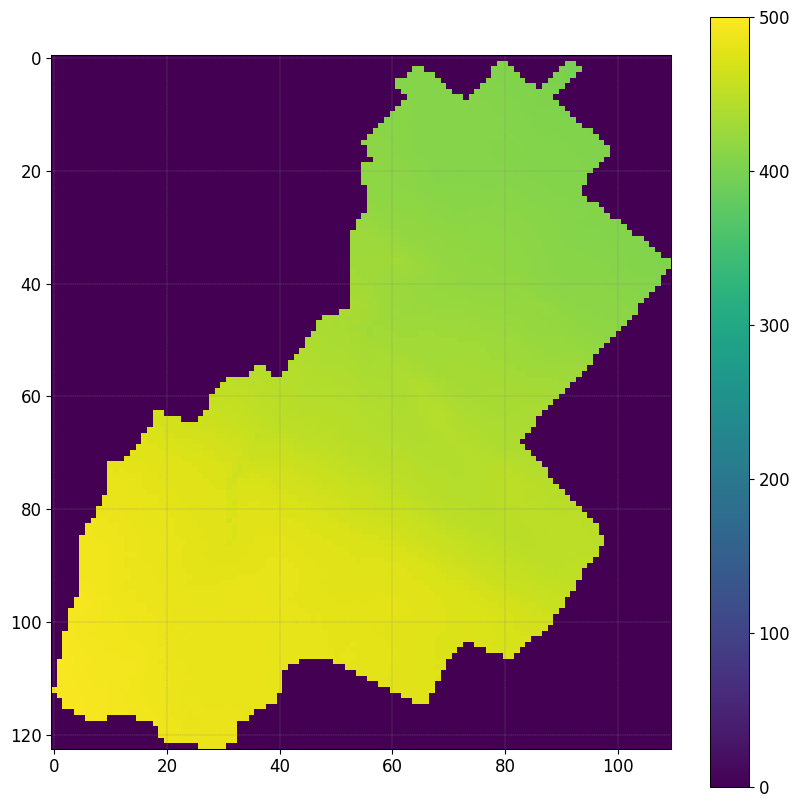

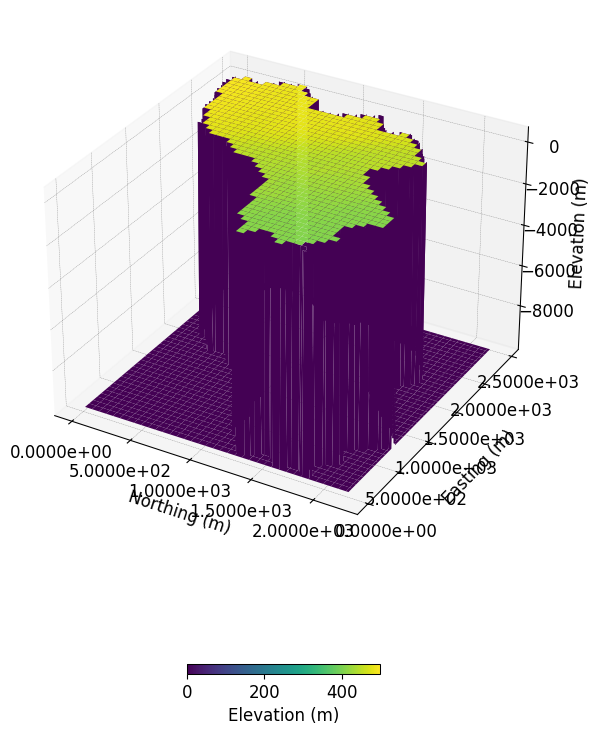

In [4]:
fig, ax = plt.subplots(1)
img = ax.imshow(DEM,vmin=0,vmax=500)
plt.colorbar(img)
simu.show_input(prop="dem",vmin=0,vmax=500)

### Define root map properties 

The **`veg_map`** is a raster file that defined the position of the vegetation.

In [5]:
VEG_MAP, header_veg_map = simu.read_inputs('root_map')
VEG_MAP

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

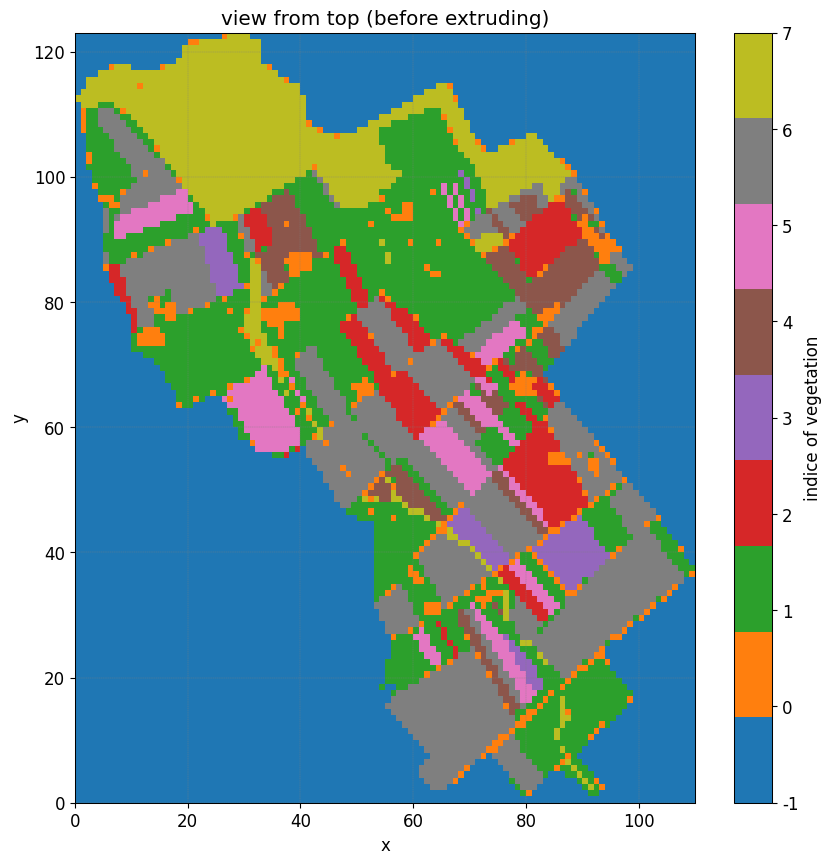

In [6]:
fig, ax = plt.subplots(1)
simu.show_input(prop="root_map", ax=ax,
               linewidth=0)


The figure illustrates the vegetation indices, with each index associated with a corresponding pair of Feddes parameters. In the northern region, represented by the forested areas, a root depth of 2 meters is considered. However, in the orange patches indicating urban areas, the root depth is set to a significantly smaller value of 1e-3.

Now we check the values of the Feddes parameters associated with the indice of the vegetation

```{note} Feddes parameters
- `PCANA`: anaerobiosis point
- `PCREF`: field capacity
- `PCWLT`: wilting point
- `ZROOT`: root depth
- `PZ`: pz is an empirical parameter
- `OMGC`: 0<OMGC<1 Compensatory mechanisms for root water uptake
```

In [7]:
SPP, FP = simu.read_inputs('soil', MAXVEG=8)
FP

,PCANA,PCREF,PCWLT,ZROOT,PZ,OMGC
Veg. Indice,,,,,,
0,0.0,-4.0,-150.0,0.001,1.0,1.0
1,0.0,-4.0,-150.0,0.300,1.0,1.0
2,0.0,-4.0,-150.0,0.400,1.0,1.0
3,0.0,-4.0,-150.0,0.500,1.0,1.0
4,0.0,-4.0,-150.0,0.800,1.0,1.0
5,0.0,-4.0,-150.0,0.900,1.0,1.0
6,0.0,-4.0,-150.0,1.000,1.0,1.0
7,0.0,-4.0,-150.0,2.000,1.0,1.0


We can also plot the spatial distribution of the Feddes parameters

excluding outside DEM

MAXVEG=8

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

                            The parm dictionnary is empty
                            Falling back to defaults to update CATHYH
                            This can have consequences !!
                            

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

🔄 update parm file 

🔄 Update soil

homogeneous soil

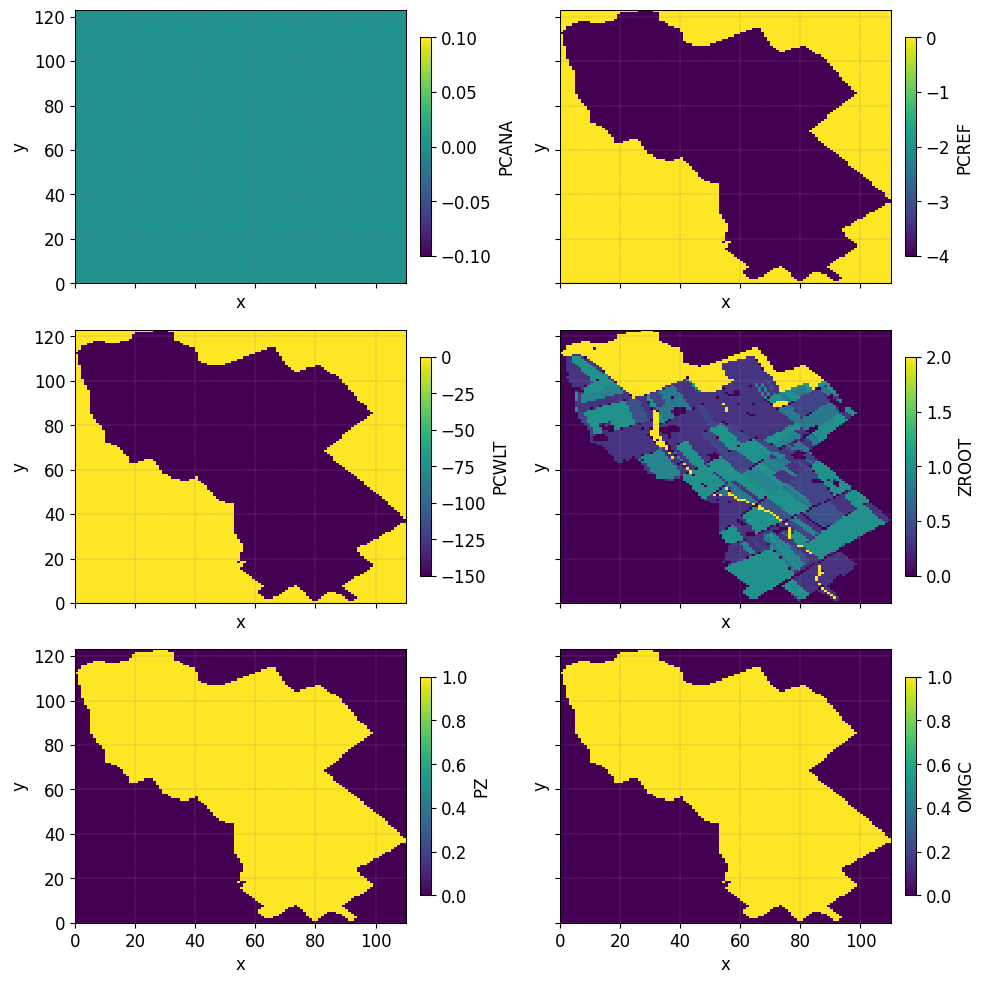

In [8]:
simu.update_veg_map()
simu.update_soil(FP_map=FP, show=True)

### Setting the atmospheric boundary conditions

**Scenario 1**, excludes irrigation from the reference simulation. This scenario serves primarily to assess the differences between an agricultural catchment and a natural one.

In order to update the atmospheric boundary conditions we call the following function:
```python
simu.update_atmbc()
```
Remenber that the functions arguments details can be assessed via: 

```python
help(simu.update_atmbc())
```

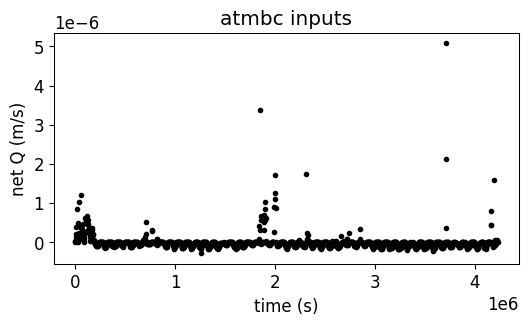

In [9]:
# first we read and plot the current atmbc file 
# --------------------------------
df_atmbc = simu.read_inputs('atmbc')
simu.show_input('atmbc')

Given the fact that all the values are defined in net Q (m/s), and that all the values are >0, here the scenario exclude the irrigation from the atmospheric boundary conditions.

Let's update the atmbc values without to with irrigation:

In [10]:
# first we read the atmbc file 
# --------------------------------
atmbc_hourlyf = os.path.join(simu.workdir,simu.project_name,'input','atmbc_hourly')
df_atmbc_hourly, HSPATM, IETO = in_CT.read_atmbc(atmbc_hourlyf)

In [11]:
help(simu.update_atmbc)
df_atmbc_hourly = df_atmbc_hourly.iloc[0:-2]

Help on method update_atmbc in module pyCATHY.cathy_tools:

update_atmbc(HSPATM=1, IETO=0, time=None, VALUE=[None, None], netValue=[], show=False, verbose=False, **kwargs) method of pyCATHY.cathy_tools.CATHY instance
    Atmospheric forcing term (atmbc - IIN6)
    
    ..note:
    
    
            1 1                HSPATM,IETO
            0.0000000e+00      time
            5.5e-06              VALUE
            12.000000e+03      time
            0.00                 VALUE
            18.000000e+03      time
            0.00                 VALUE
    
            The values are those of a 200-min rainfall event at a uniform
            intensity of 3.3·10-4 m/min, followed by 100 min of drainage.
    
    ..note:
    
            In case of simultaneous precipitation and evaporation, we impose at
            the surface the net flux, i.e., precipitation minus evaporation.
    
    
    
    
    
    Parameters
    ----------
    HSPATM : int, optional
        - =0 for spatially var

In [12]:
simu.update_atmbc(
                    HSPATM=1,
                    IETO=0,
                    time=df_atmbc_hourly['time'],
                    netValue=df_atmbc_hourly['value'],
)
simu.show_input('atmbc')

🔄 Update atmbc

KeyError: -1

### Scenario with varying Feddes parameters

In **Scenario 2**, we additionally **excluded the effect of oxygen stress**, whereby roots could take up water even when soil moisture exceeded a threshold according to the Feddes approach

```python
simu.update_soil(FP=new_feddes_parameters)
```

We considered two test cases in **Scenario 3**. Starting from Scenario 2, we assumed a **homogeneous rooting depth** of 0.3 m in the first case and of 2.0 m in the second one.

```python
simu.update_soil(FP=new_feddes_parameters)
```


In [13]:
# first we read the current soil file 
# --------------------------------
simu.update_veg_map()
df_soil_het, df_FP = simu.read_inputs('soil')

# show Feddes parameters table
# --------------------------------
df_FP

,PCANA,PCREF,PCWLT,ZROOT,PZ,OMGC
Veg. Indice,,,,,,
0,0.0,-4.0,-150.0,0.001,1.0,1.0
1,0.0,-4.0,-150.0,0.300,1.0,1.0
2,0.0,-4.0,-150.0,0.400,1.0,1.0
3,0.0,-4.0,-150.0,0.500,1.0,1.0
4,0.0,-4.0,-150.0,0.800,1.0,1.0
5,0.0,-4.0,-150.0,0.900,1.0,1.0
6,0.0,-4.0,-150.0,1.000,1.0,1.0
7,0.0,-4.0,-150.0,2.000,1.0,1.0


From the table above we observe the values of the Feddes parameters for the different zones defined in the figure above. Here Zroot is varying according to the root map zone. 

### Check soil properties


The project folder includes:
- A file with **homogeneous** properties
- A file with **heterogeneous** properties for which the hydraulic conductivity of the layer number 6 is set to $0.001 m-s^{-1}$ (>0.000073 for other layers) 

The soil is discretise in 3 distinct layers: 

| Depth (cm) | Porosity | Residual moisture content | Van Genuchten / (cm^-1) | Van Genuchten n | Specific storage coefficient (m^-1) | Saturated hydraulic conductivity (m/s) |
| --- | --- | --- | --- | --- | --- | --- |
| 0-80 | 0.43 | 0.078 | 0.036 | 1.56 | 1.00 x 10^-3 | 7.3 x 10^-5 |
| 80-140 (Tile-drain) | 0.43 | 0.078 | 0.036 | 1.56 | 1.00 x 10^-3 | 1.0 x 10^-3 | 
| 140–500 | 0.43 | 0.078 | 0.036 | 1.56 | 1.00 x 10^-3 | 7.3 x 10^-5 |



```{note} Van Genuchten parameters in CATHY
- `PERMX` (NSTR, NZONE): saturated hydraulic conductivity - xx
- `PERMY` (NSTR, NZONE): saturated hydraulic conductivity - yy
- `PERMZ` (NSTR, NZONE): saturated hydraulic conductivity - zz
- `ELSTOR` (NSTR, NZONE): specific storage
- `POROS`  (NSTR, NZONE): porosity (moisture content at saturation) = \thetaS

Retention curves parameters VGN, VGRMC, and VGPSAT
- `VGNCELL` (NSTR, NZONE): van Genuchten curve exponent  = n
- `VGRMCCELL` (NSTR, NZONE): residual moisture content = \thetaR
- `VGPSATCELL` (NSTR, NZONE): van Genuchten curve exponent -->
- `VGPSAT` == -1/alpha (with alpha expressed in [L-1]);
```





In [14]:
df_soil, df_FP = simu.read_inputs('soil')
df_soil

,,PERMX,PERMY,PERMZ,ELSTOR,POROS,VGNCELL,VGRMCCELL,VGPSATCELL
str,zone,,,,,,,,
0,0,0.000188,0.000188,0.000188,0.00001,0.55,1.46,0.15,0.03125
1,0,0.000188,0.000188,0.000188,0.00001,0.55,1.46,0.15,0.03125
2,0,0.000188,0.000188,0.000188,0.00001,0.55,1.46,0.15,0.03125
3,0,0.000188,0.000188,0.000188,0.00001,0.55,1.46,0.15,0.03125
4,0,0.000188,0.000188,0.000188,0.00001,0.55,1.46,0.15,0.03125
5,0,0.000188,0.000188,0.000188,0.00001,0.55,1.46,0.15,0.03125
6,0,0.000188,0.000188,0.000188,0.00001,0.55,1.46,0.15,0.03125
7,0,0.000188,0.000188,0.000188,0.00001,0.55,1.46,0.15,0.03125
8,0,0.000188,0.000188,0.000188,0.00001,0.55,1.46,0.15,0.03125


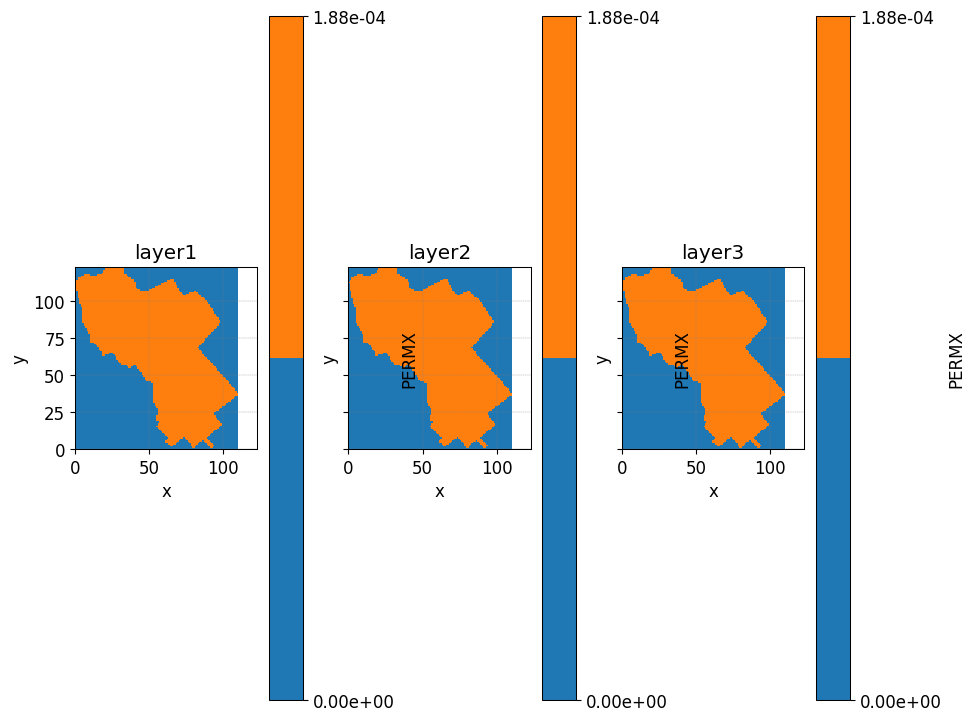

In [15]:
layers2plot= [1,6,9]

fig, axs = plt.subplots(1,3, 
                        sharex=True, 
                        sharey=True
                       )
axs= axs.ravel()
for i, ax in enumerate(axs):
    simu.show_input(
                    prop="soil", 
                    yprop="PERMX", 
                    layer_nb=layers2plot[i],
                    ax = ax,
                    linewidth=0,
                   )
    ax.axis('square')
    ax.set_title('layer'+ str(i+1))


Read soil file with Tile-drain (and update existing soil file)


```{warning} pyCATHY naming convention
The project folder comes with the default naming convention for the filenames. If you decide to rename the `soil` file, then you have to update the pyCATHY wrapper with the new values (this will overwrite the soil file). 
```


In [16]:
# define the path to the soil file
soilfile_het = os.path.join(simu.workdir,simu.project_name,'input','soil_het')

# define the path to the dem_parameter file
dem_parmfile = os.path.join(simu.workdir,simu.project_name,'input','dem_parameters')

# define the path to the dem_parameter file
dempar = in_CT.read_dem_parameters(dem_parmfile)

# read soil heterogeneous file
df_soil_het, _ = in_CT.read_soil(soilfile_het,dempar,MAXVEG=8)
df_soil_het

,,PERMX,PERMY,PERMZ,ELSTOR,POROS,VGNCELL,VGRMCCELL,VGPSATCELL
str,zone,,,,,,,,
0,0,0.000073,0.000073,0.000073,0.001,0.43,1.56,0.078,0.27778
1,0,0.000073,0.000073,0.000073,0.001,0.43,1.56,0.078,0.27778
2,0,0.000073,0.000073,0.000073,0.001,0.43,1.56,0.078,0.27778
3,0,0.000073,0.000073,0.000073,0.001,0.43,1.56,0.078,0.27778
4,0,0.000073,0.000073,0.000073,0.001,0.43,1.56,0.078,0.27778
5,0,0.001000,0.001000,0.001000,0.001,0.43,1.56,0.078,0.27778
6,0,0.000073,0.000073,0.000073,0.001,0.43,1.56,0.078,0.27778
7,0,0.000073,0.000073,0.000073,0.001,0.43,1.56,0.078,0.27778
8,0,0.000073,0.000073,0.000073,0.001,0.43,1.56,0.078,0.27778


In [17]:
simu.update_soil(SPP=df_soil_het)

🔄 Update soil

homogeneous soil

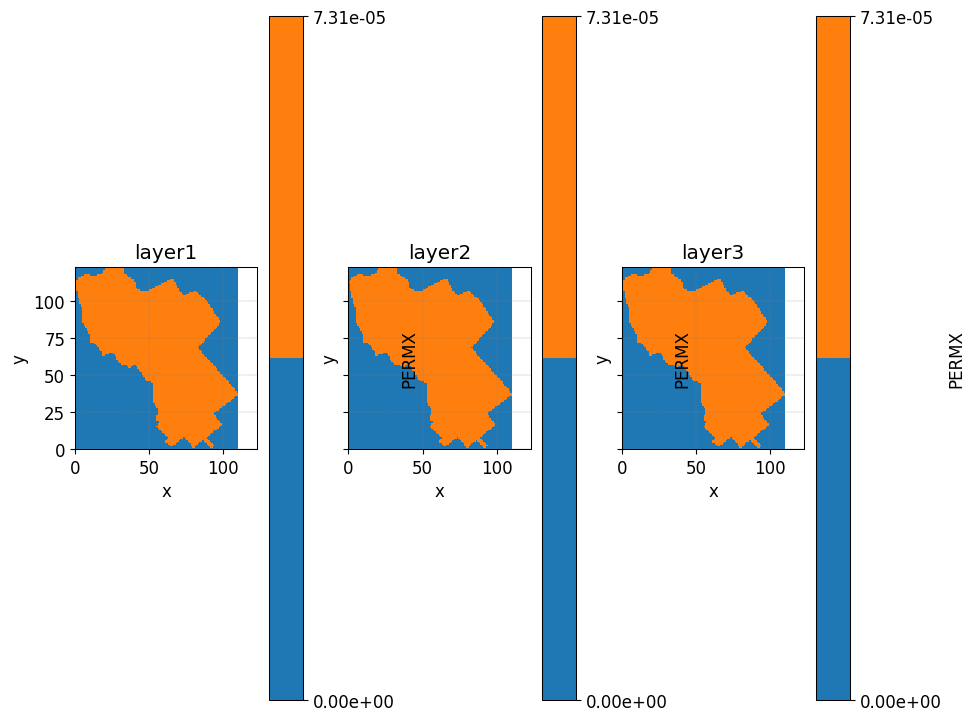

In [18]:
layers2plot= [1,6,9]

fig, axs = plt.subplots(1,3, 
                        sharex=True, 
                        sharey=True
                       )
axs= axs.ravel()
for i, ax in enumerate(axs):
    simu.show_input(
                    prop="soil", 
                    yprop="PERMX", 
                    layer_nb=layers2plot[i],
                    ax = ax,
                    linewidth=0,
                   )
    ax.axis('square')
    ax.set_title('layer'+ str(i+1))

## 2. Run simulation

Once all the inputs files are updated according to the scenario, it is good practice to run first the preprocessor in verbose = True mode to check if the preprocessing step worked. 

Then we can run the processor. As the number of times and points are large in this example it is recommanded to execute it locally.

```python
simu.run_preprocessor(verbose=True)
simu.run_processor(
                   IPRT1=2,
                   ROWMAX=247, 
                   COLMAX=221
                   )

```{tip} Check before running the simulations
Before running the simulation it is recommanded to check the parm file
```

In [19]:
#simu.read_inputs('parm')
parm_file = os.path.join(simu.workdir,simu.project_name,'input','parm')
parm = in_CT.read_parm(parm_file)

Among all the parameters (check using parm.keys()) controlling the behavior of the simulation here is a selection of some important ones: 

- `IPRT1` Flag for output of input and coordinate data;
- `TRAFLAG` lag for the choice of the data assimilation scheme;
- `DTMIN` Minimum FLOW3D time step size allowed;
- `NPRT` Number of time values for detailed nodal output and element velocity output;
- `(TIMPRT(I),I=1,NPRT)` Time values for detailed output.

## 3. Plot outputs

### Plot streamflow

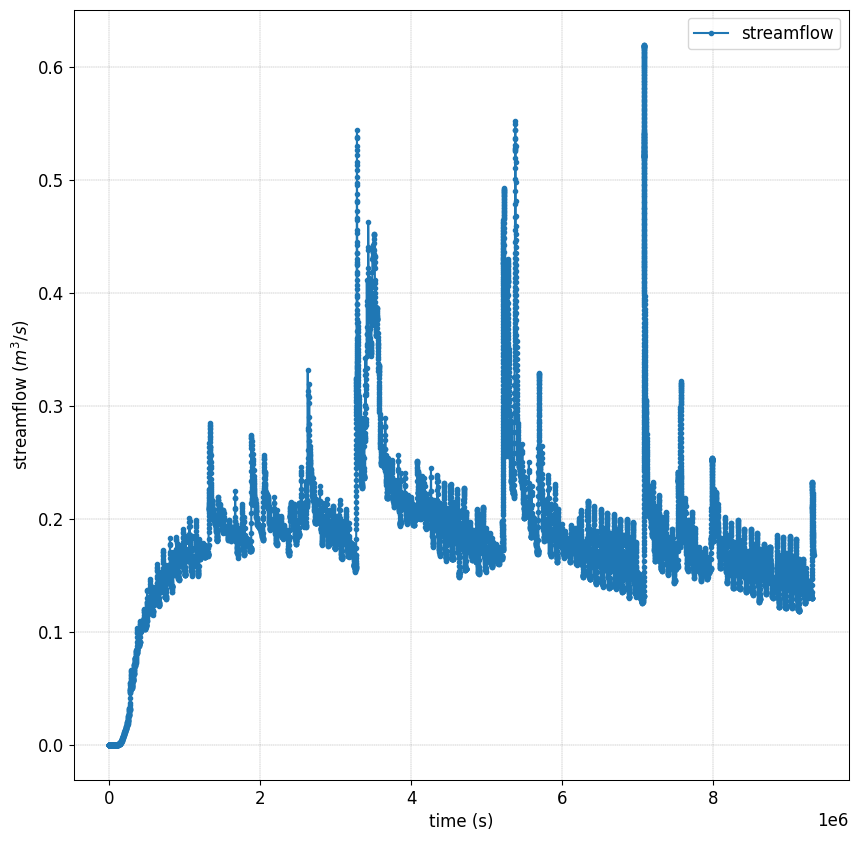

In [20]:
#%% Another interesting graph looking at the **streamflow = f(time)**
simu.show(prop="hgraph")

### Plot spatial actual ET

no file specified

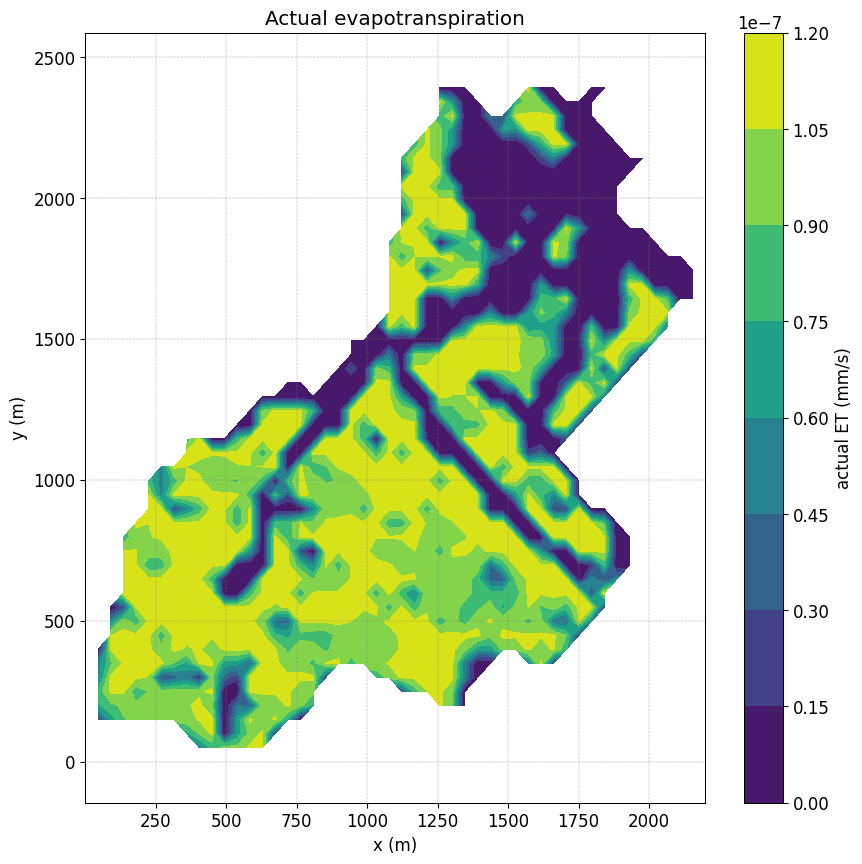

In [21]:
fig, ax = plt.subplots(1)
simu.show('spatialET',ax=ax, ti=10)

### Plot the Ground Water Depth (GWD)

no file specified

no file specified

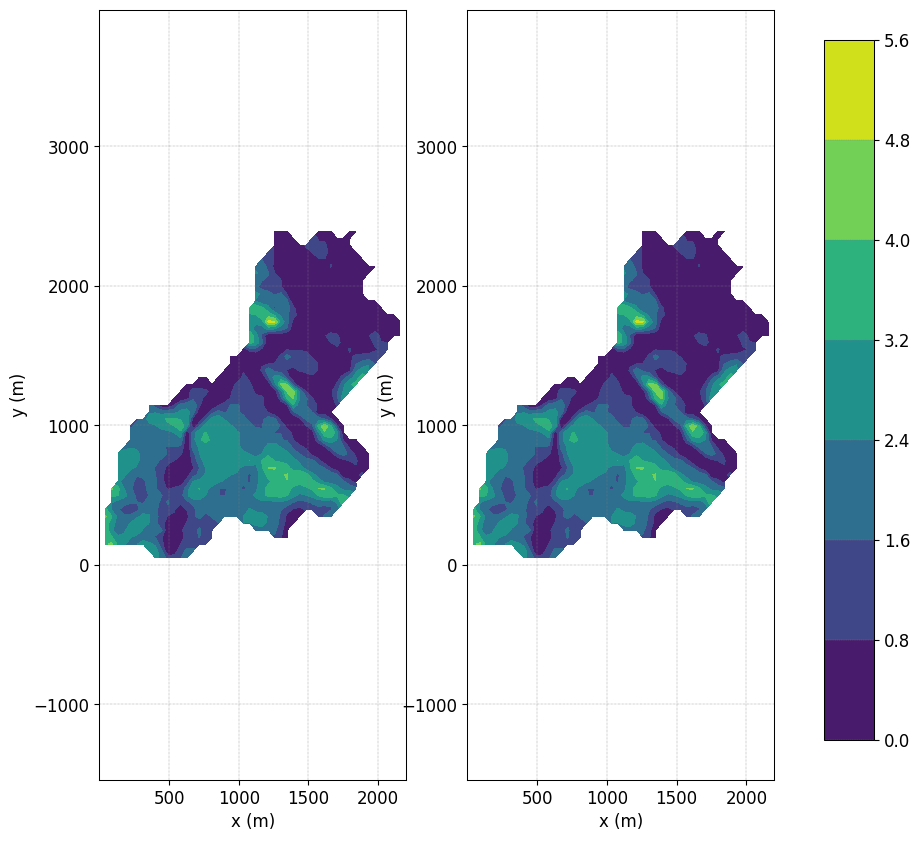

In [22]:
fig, axs = plt.subplots(1,2)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])

cmap = simu.show('WTD',ax=axs[0], ti=9, colorbar=False)
cmap = simu.show('WTD',ax=axs[1], ti=10, colorbar=False)

plt.colorbar(cmap,cax=cbar_ax)

```{tip} Compute differences
In order to compute the differences between two times pass a list of time to ti
```

no file specified

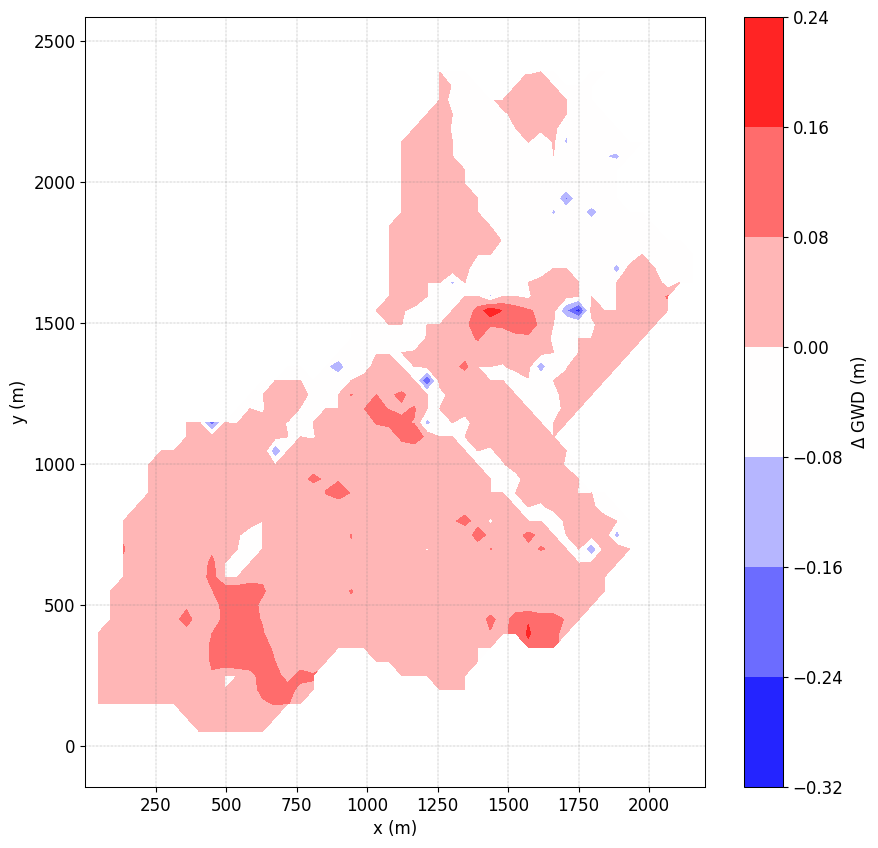

In [23]:
simu.show('WTD',ti=[1,10])